In [1]:
import time

# Device configuration and core PyTorch setup
import torch
import torch.nn as nn
import torch.nn.functional as F
DTYPE = torch.float32
device = torch.device('cuda')
if device.type == "cuda":
    torch.cuda.init()
    torch.rand(1, device=device)
print(f"Using device: {device}")

from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from SA_PINN_ACTO import PINN_BDNK_1D
from IC_1D import IC_BDNK

# Hyperparameters for network architecture and training schedule
Nl, Nn = 10, 70
t_end = 20.0
L = 50.0
adam_epochs = 25_000
lr_net = 5e-3
lr_mask = 4e-2 

# BDNK simulation configuration and background field setup
from BDNK_Functions import *
BDNK_simulation = 2
setup_external_Tv(BDNK_simulation, L)

# Sampling parameters and domain sampling
N_colloc = 20000
# In the ACTO case, the N_ic below are not collocation points where an IC residual will be computed,
# but points at which the exact initial condition gets computed
N_ic = 1000

def lhs_box(n, low, high, rng=np.random):
    low, high = np.asarray(low, float), np.asarray(high, float)
    D = low.size
    H = np.empty((n, D), float)
    for j in range(D):
        P = (rng.permutation(n) + rng.rand(n)) / n
        H[:, j] = low[j] + P * (high[j] - low[j])
    return H
    
X_colloc_np = lhs_box(N_colloc, low=np.array([0.0, -L]), high=np.array([t_end, L])).astype(np.float32)

# Construction of initial condition sampling grid
x_edges = np.linspace(-L, L, N_ic+1)
x_ic = (0.5 * (x_edges[:-1] + x_edges[1:])).reshape(-1, 1)
t_ic = np.zeros_like(x_ic)
X_ic = np.hstack((t_ic, x_ic))

X_ic_t = torch.tensor(X_ic, dtype=DTYPE, device=device)
J0_ic_t, alpha_ic_t, _ = IC_BDNK(X_ic_t, L)

# Scaling factors for numerical stability of IC enforcement
with torch.no_grad():
    sJ0 = J0_ic_t.abs().max().clamp_min(1e-12).item()
    sA  = alpha_ic_t.abs().max().clamp_min(1e-12).item()
print(f"[scales] sJ0={sJ0:.3e}, sA={sA:.3e}")

# Sorting IC data to enable fast 1D interpolation
x_ic_torch = X_ic_t[:, 1:2].contiguous().view(-1)
x_sorted, idx_sort = torch.sort(x_ic_torch)
J0_sorted    = J0_ic_t.view(-1)[idx_sort]
alpha_sorted = alpha_ic_t.view(-1)[idx_sort]

@torch.no_grad()
def _torch_lin_interp_1d(xq: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    xq_flat = xq.view(-1)
    xq_clamped = xq_flat.clamp(min=x[0], max=x[-1])
    idx_hi = torch.searchsorted(x, xq_clamped, right=True)
    idx_hi = idx_hi.clamp(min=1, max=x.numel() - 1)
    idx_lo = idx_hi - 1
    x0 = x[idx_lo]; x1 = x[idx_hi]
    y0 = y[idx_lo]; y1 = y[idx_hi]
    denom = (x1 - x0)
    denom = torch.where(denom.abs() > 0, denom, torch.ones_like(denom))
    w = (xq_clamped - x0) / denom
    yq = y0 + w * (y1 - y0)
    return yq.view_as(xq)

# Initial condition functions passed to the neural network (physical scale)
def J0_ic_func(x_phys: torch.Tensor) -> torch.Tensor:
    if x_sorted.device != x_phys.device or x_sorted.dtype != x_phys.dtype:
        xk = x_sorted.to(device=x_phys.device, dtype=x_phys.dtype)
        yk = J0_sorted.to(device=x_phys.device, dtype=x_phys.dtype)
    else:
        xk, yk = x_sorted, J0_sorted
    yq = _torch_lin_interp_1d(x_phys.view(-1), xk, yk)
    return yq.view(-1, 1)

def alpha_ic_func(x_phys: torch.Tensor) -> torch.Tensor:
    if x_sorted.device != x_phys.device or x_sorted.dtype != x_phys.dtype:
        xk = x_sorted.to(device=x_phys.device, dtype=x_phys.dtype)
        yk = alpha_sorted.to(device=x_phys.device, dtype=x_phys.dtype)
    else:
        xk, yk = x_sorted, alpha_sorted
    yq = _torch_lin_interp_1d(x_phys.view(-1), xk, yk)
    return yq.view(-1, 1)

# Scaled initial condition functions (used internally by the model)
def J0_ic_func_scaled(x_phys: torch.Tensor) -> torch.Tensor:
    return J0_ic_func(x_phys) / sJ0

def alpha_ic_func_scaled(x_phys: torch.Tensor) -> torch.Tensor:
    return alpha_ic_func(x_phys) / sA
    
X_colloc = torch.tensor(X_colloc_np, dtype=DTYPE, device=device)
x0_line = torch.linspace(-L, L, 500, dtype=DTYPE, device=device).unsqueeze(1)
X0 = torch.cat([torch.zeros_like(x0_line), x0_line], dim=1)
X_colloc = torch.cat([X_colloc, X0], dim=0)

# Self-adaptive collocation mask (learned weighting of PDE residual)
pde_logits = torch.nn.Parameter(torch.zeros((X_colloc.shape[0], 1), dtype=DTYPE, device=device))
def current_masks(detach: bool = False):
    pde = F.softplus(pde_logits)
    return pde.detach() if detach else pde

# Model instantiation and domain normalization
lb = torch.tensor([0.0, -L], dtype=DTYPE, device=device)
ub = torch.tensor([t_end,  L], dtype=DTYPE, device=device)
model = PINN_BDNK_1D(Nl=Nl, Nn=Nn, lb=lb, ub=ub).to(device).to(DTYPE)
model.J0_ic_func    = J0_ic_func_scaled
model.alpha_ic_func = alpha_ic_func_scaled
model.sJ0.copy_(torch.tensor(sJ0, dtype=DTYPE, device=device))
model.sA.copy_(torch.tensor(sA,  dtype=DTYPE, device=device))

# Weight initialization
def glorot_normal_all_linear(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, gain=1.0)
        if m.bias is not None: nn.init.zeros_(m.bias)
model.apply(glorot_normal_all_linear)

# Optimizers and learning-rate scheduler setup
optimizer_theta = torch.optim.Adam(model.parameters(), lr=lr_net, betas=(0.9, 0.95))
scheduler = ReduceLROnPlateau(optimizer_theta, mode='min', factor=0.4, patience=700, threshold=1e-4, min_lr=lr_net/100)
optimizer_mask  = torch.optim.Adam([pde_logits], lr=lr_mask, betas=(0.7, 0.85), maximize=True)

# Setting up and executing Adam pre-training
def train_adam(model, optimizer_theta, optimizer_mask, epochs, print_every):
    print("Starting Adam pre-training (SA-PINN with hard IC)...")
    best_loss, best_state = float('inf'), None
    loss_history = []

    for epoch in range(1, epochs + 1):
        optimizer_theta.zero_grad()
        optimizer_mask.zero_grad()

        R = model.pde_residual(X_colloc)
        R1, R2 = R[:, 0:1], R[:, 1:2]
        
        Rnorm = torch.sqrt(R1**2 + R2**2)
        pde_mask = current_masks(detach=False)
        L_pde = (pde_mask * Rnorm).pow(2).mean()

        loss = L_pde
        if not torch.isfinite(loss): raise RuntimeError("Non-finite loss detected.")
        
        L_pde_phys   = (R1**2 + R2**2).mean()
        L_total_phys = L_pde_phys

        loss.backward()
        optimizer_theta.step()
        scheduler.step(L_total_phys.item())
        optimizer_mask.step()

        ltp = L_total_phys.detach().item()
        loss_history.append(ltp)
        if ltp < best_loss:
            best_loss = ltp
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch % print_every == 0 or epoch == epochs:
            with torch.no_grad():
                m_pde = current_masks(detach=True)
            print(f"Adam Epoch {epoch}/{epochs} | "
                  f"Total={loss:.3e}, PDE={L_pde.item():.3e}, <pde_mask>={m_pde.mean().item():.2f} | "
                  f"Unmasked: Total={L_total_phys:.3e}, PDE={L_pde_phys.item():.3e} | "
                  f"lr_net={optimizer_theta.param_groups[0]['lr']:.3e}")

    if best_state is not None:
        model.load_state_dict(best_state)
        with torch.enable_grad():
            R = model.pde_residual(X_colloc)
            L_pde_phys = ((R[:,0:1]**2 + R[:,1:2]**2)).mean()
        print(f"\nAdam finished. Best loss = {best_loss:.3e} | PDE={L_pde_phys.item():.4e}")
    
    return best_loss, loss_history, best_state
    
start_training = time.time()
adam_loss, adam_loss_history, best_state = train_adam(model, optimizer_theta, optimizer_mask, adam_epochs, print_every=1000)
adam_training_finished = time.time()

model.load_state_dict(best_state)

# Setting up executing L-BFGS fine-tuning
with torch.enable_grad():
    X_colloc.requires_grad_(True)
    res = model.pde_residual(X_colloc)
    init_lbfgs_loss = ((res[:,0:1]**2 + res[:,1:2]**2)).mean().detach().item()
print(f"LBFGS init unmasked PDE loss (from best Adam): {init_lbfgs_loss:.3e}")

loss_scale = 1.0 / max(init_lbfgs_loss, 1e-30)

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=1000,
    max_eval=1000,
    history_size=100,
    line_search_fn=None,
    tolerance_grad=1e-10,
    tolerance_change=1e-12,
)

best = {"loss": float("inf"), "state": None}
inner_curve = []

def closure():
    optimizer_lbfgs.zero_grad(set_to_none=True)
    X = X_colloc.requires_grad_(True)

    R = model.pde_residual(X)
    R1, R2 = R[:, 0:1], R[:, 1:2]
    raw = (R1.pow(2) + R2.pow(2)).mean()

    if not torch.isfinite(raw):
        print(f"NaN/Inf detected at iter {len(inner_curve)}. Exiting L-BFGS.")
        raise RuntimeError("L-BFGS_NAN")

    loss = raw * loss_scale

    raw_f = float(raw)
    if raw_f < best["loss"]:
        best["loss"] = raw_f
        best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    inner_curve.append(raw_f)

    loss.backward()
    return loss

lbfgs_training_started = time.time()
try:
    final_loss = optimizer_lbfgs.step(closure)
    final_raw = float(final_loss.item()) / loss_scale
except RuntimeError as e:
    if "L-BFGS_NAN" in str(e):
        print("L-BFGS terminated early due to NaN/Inf.")
        final_raw = float("nan")
    else:
        raise
end_training = time.time()

# Restore best L-BFGS state and record loss history
if best["state"] is not None:
    model.load_state_dict(best["state"])

lbfgs_loss_history = inner_curve

print(f"LBFGS finished. final_raw={final_raw:.4e} | best_raw={best['loss']:.4e} | inner_calls={len(inner_curve)}")

print(f"\nTotal training time: {end_training - start_training:.4f} seconds."
      f"\nAdam: {adam_training_finished - start_training:.4f} seconds. "
      f"L-BFGS: {end_training - lbfgs_training_started:.4f} seconds.")

Using device: cuda
[scales] sJ0=1.050e-03, sA=1.331e-01
Starting Adam pre-training (SA-PINN with hard IC)...
Adam Epoch 1000/25000 | Total=1.870e+00, PDE=1.870e+00, <pde_mask>=26.19 | Unmasked: Total=2.457e-03, PDE=2.457e-03 | lr_net=5.000e-03
Adam Epoch 2000/25000 | Total=2.766e+00, PDE=2.766e+00, <pde_mask>=52.46 | Unmasked: Total=8.344e-04, PDE=8.344e-04 | lr_net=5.000e-03
Adam Epoch 3000/25000 | Total=1.995e+01, PDE=1.995e+01, <pde_mask>=78.45 | Unmasked: Total=2.912e-03, PDE=2.912e-03 | lr_net=5.000e-03
Adam Epoch 4000/25000 | Total=4.372e+00, PDE=4.372e+00, <pde_mask>=103.66 | Unmasked: Total=3.607e-04, PDE=3.607e-04 | lr_net=5.000e-03
Adam Epoch 5000/25000 | Total=3.631e+00, PDE=3.631e+00, <pde_mask>=128.35 | Unmasked: Total=2.213e-04, PDE=2.213e-04 | lr_net=2.000e-03
Adam Epoch 6000/25000 | Total=8.472e-01, PDE=8.472e-01, <pde_mask>=153.69 | Unmasked: Total=3.393e-05, PDE=3.393e-05 | lr_net=2.000e-03
Adam Epoch 7000/25000 | Total=5.674e+00, PDE=5.674e+00, <pde_mask>=178.82 | Un

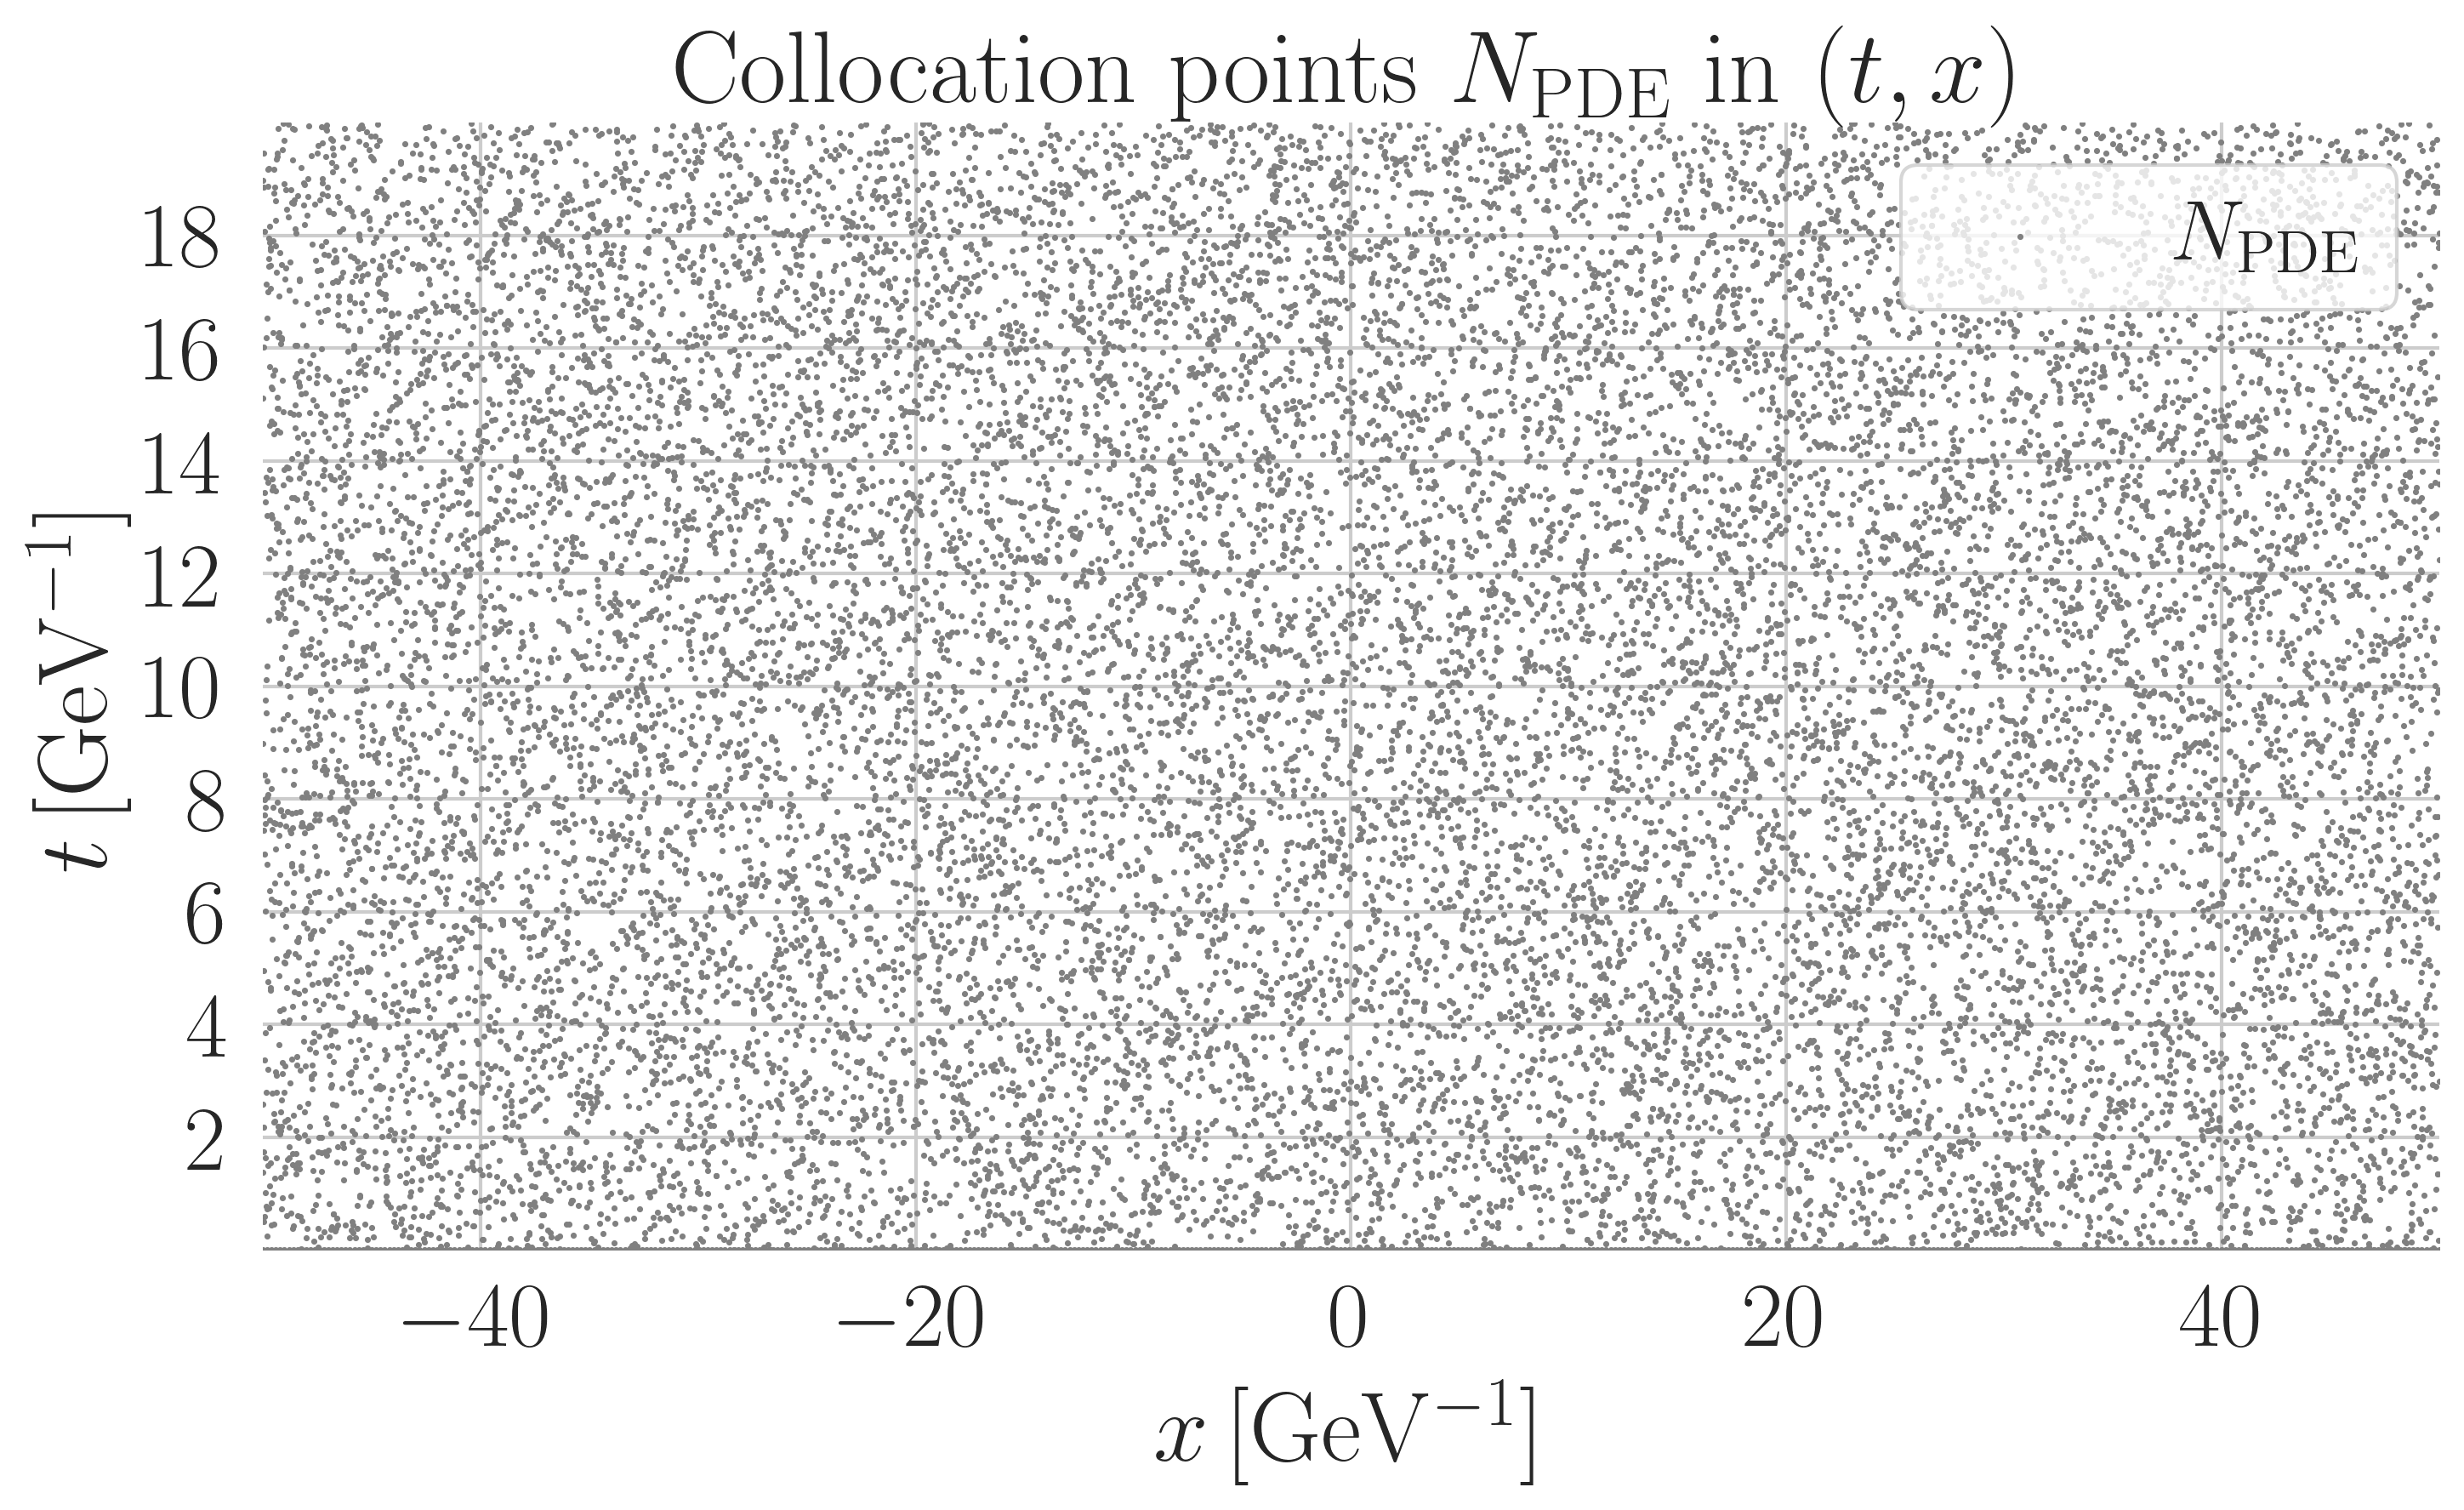

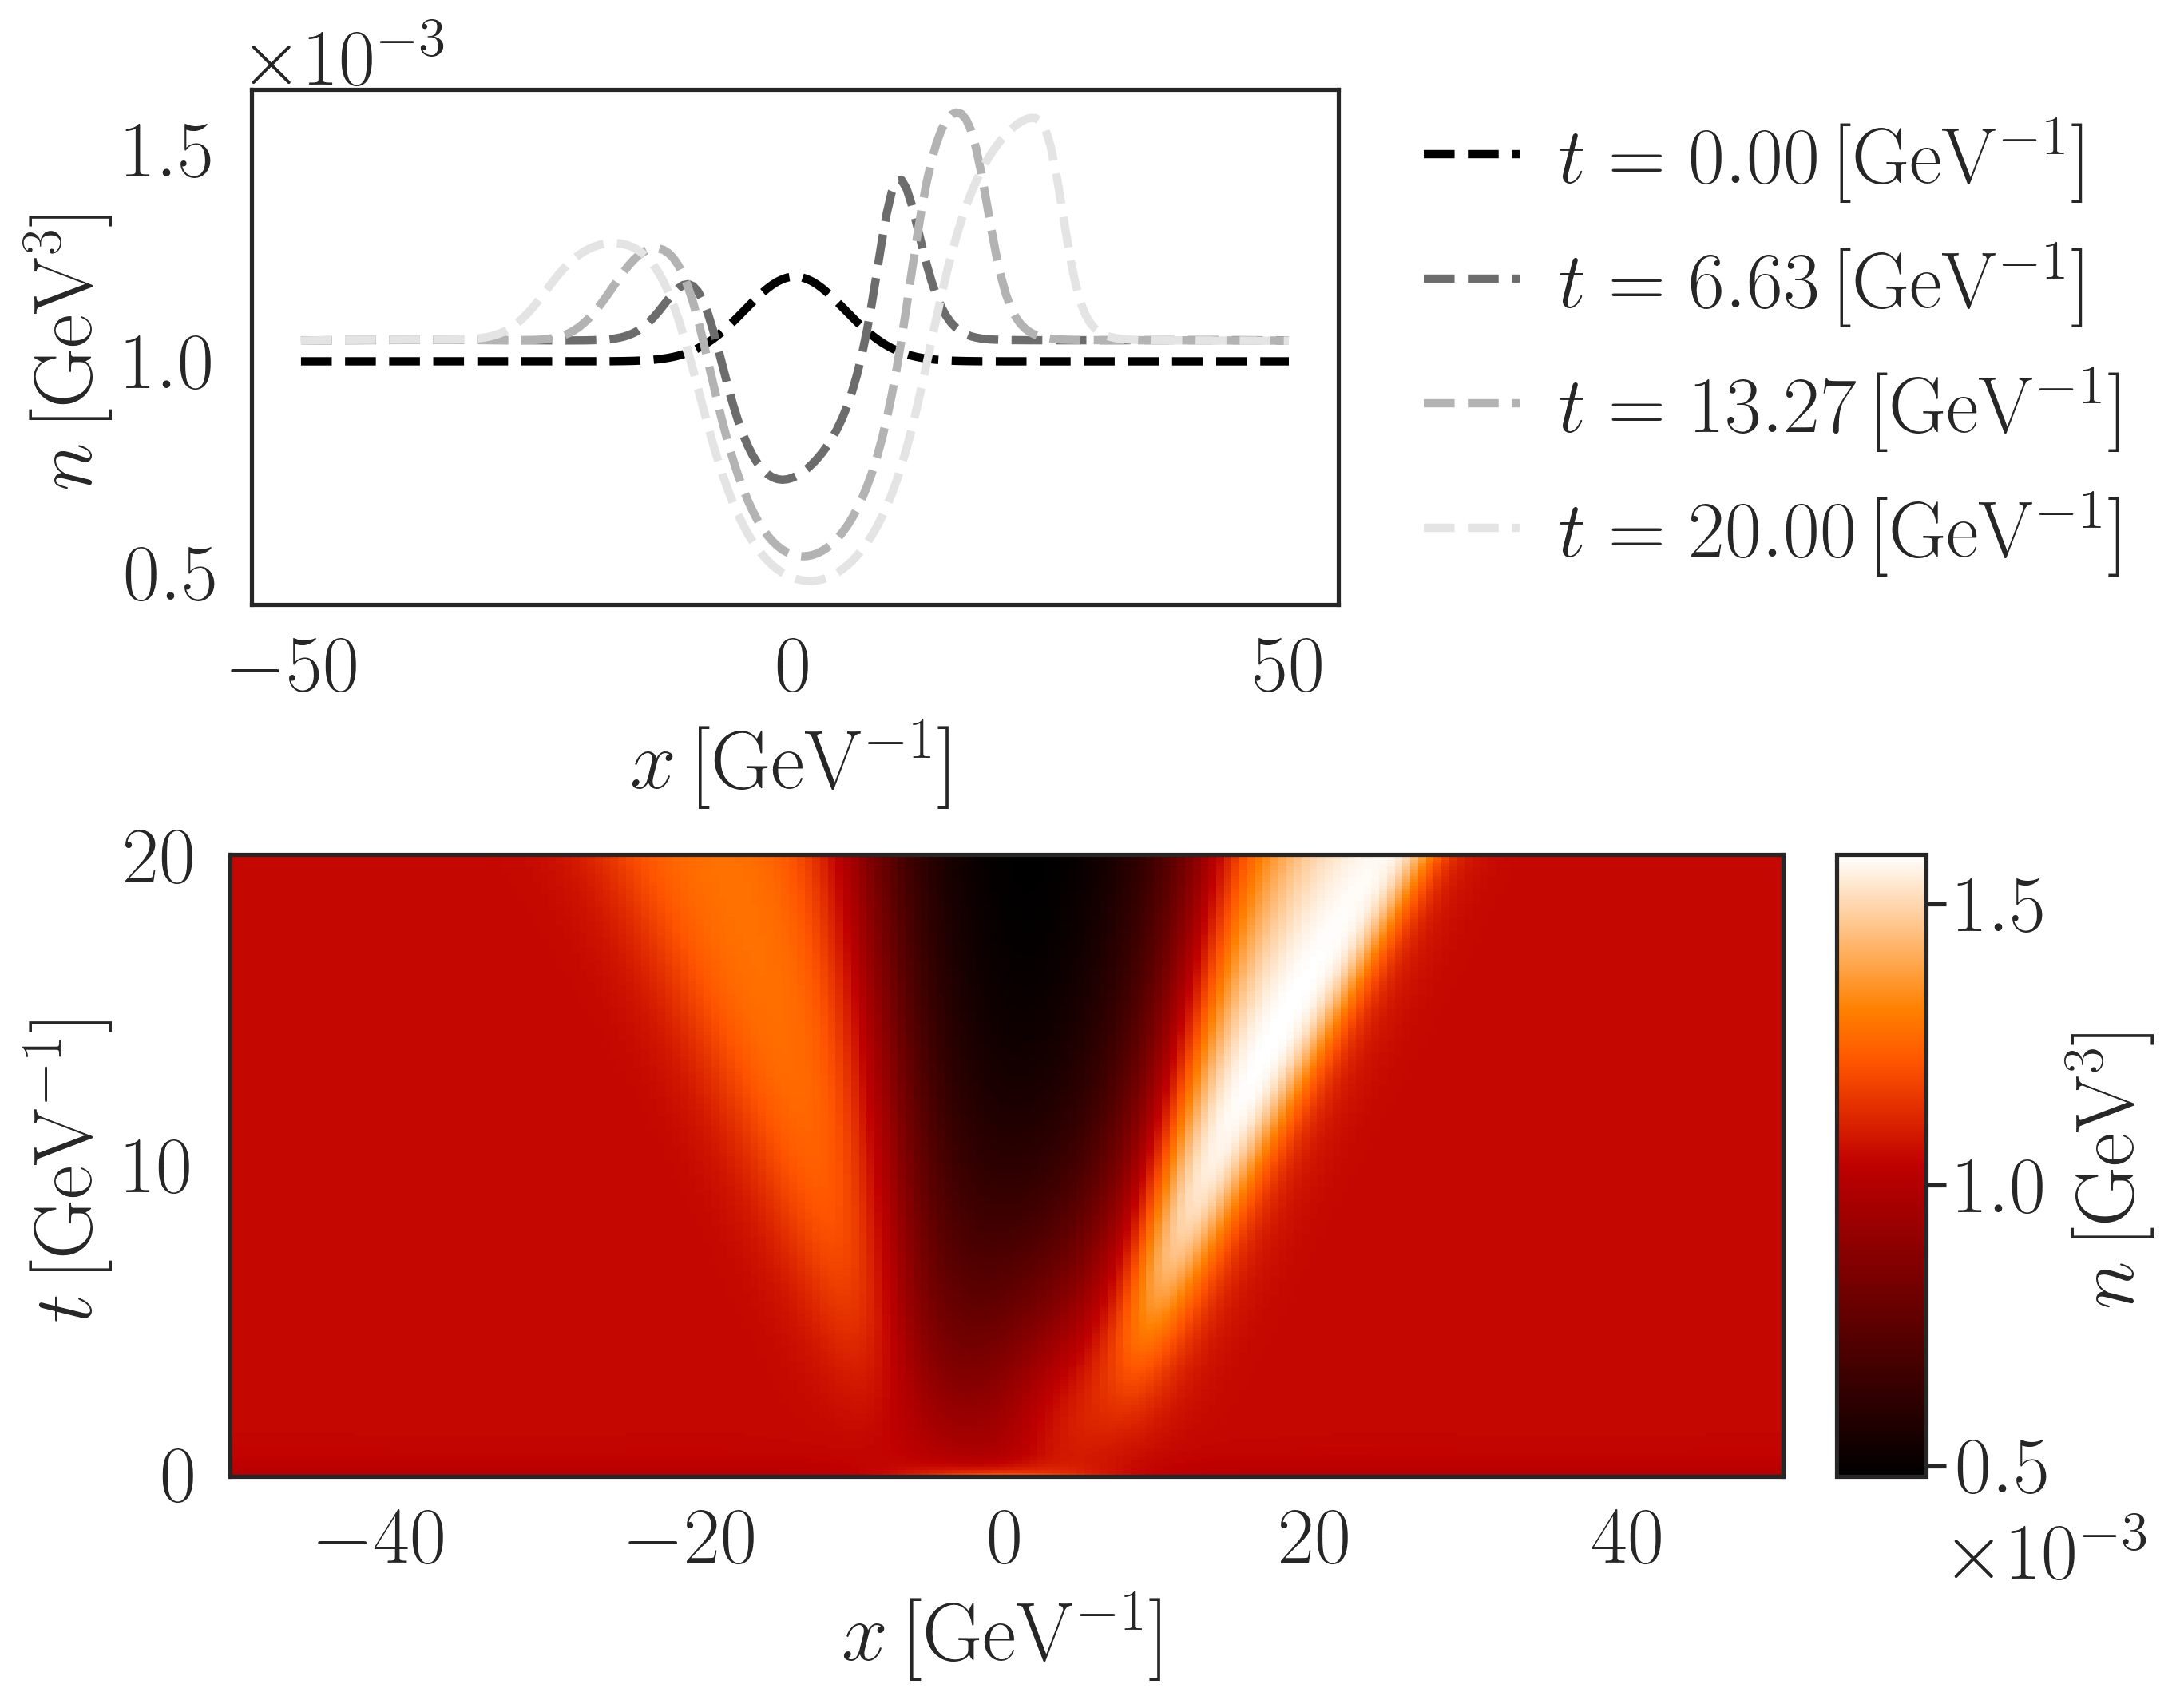

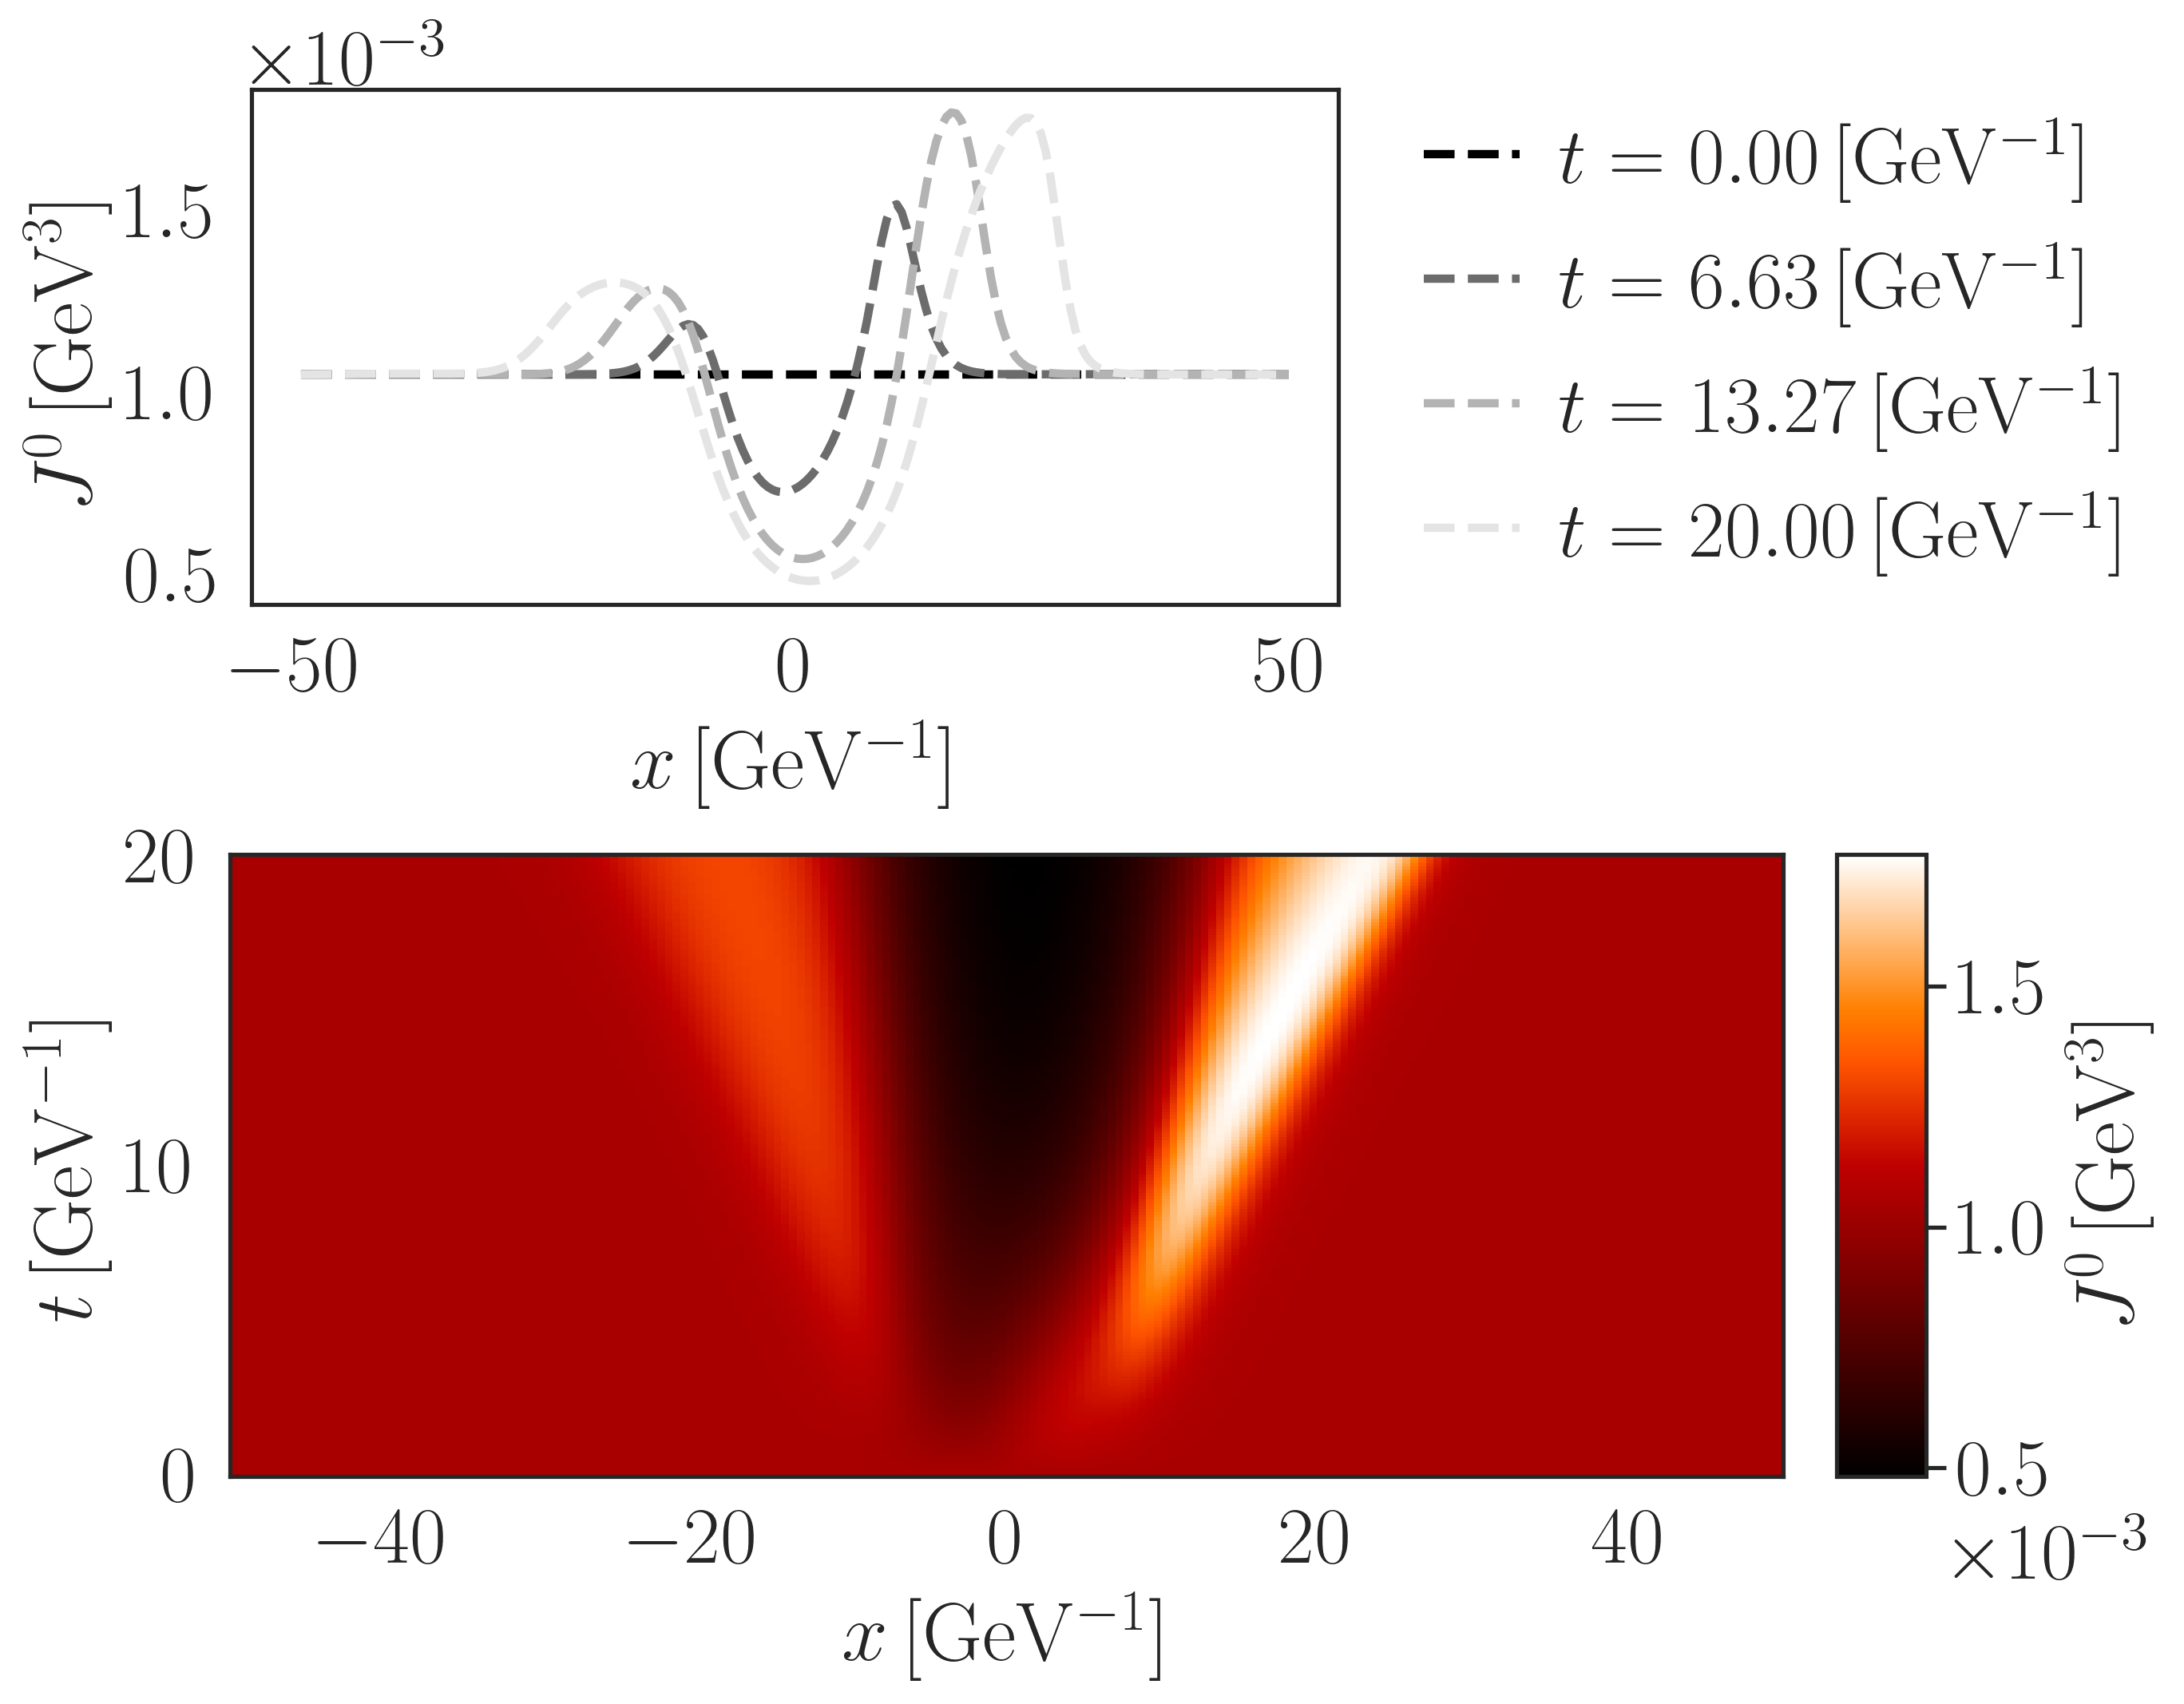

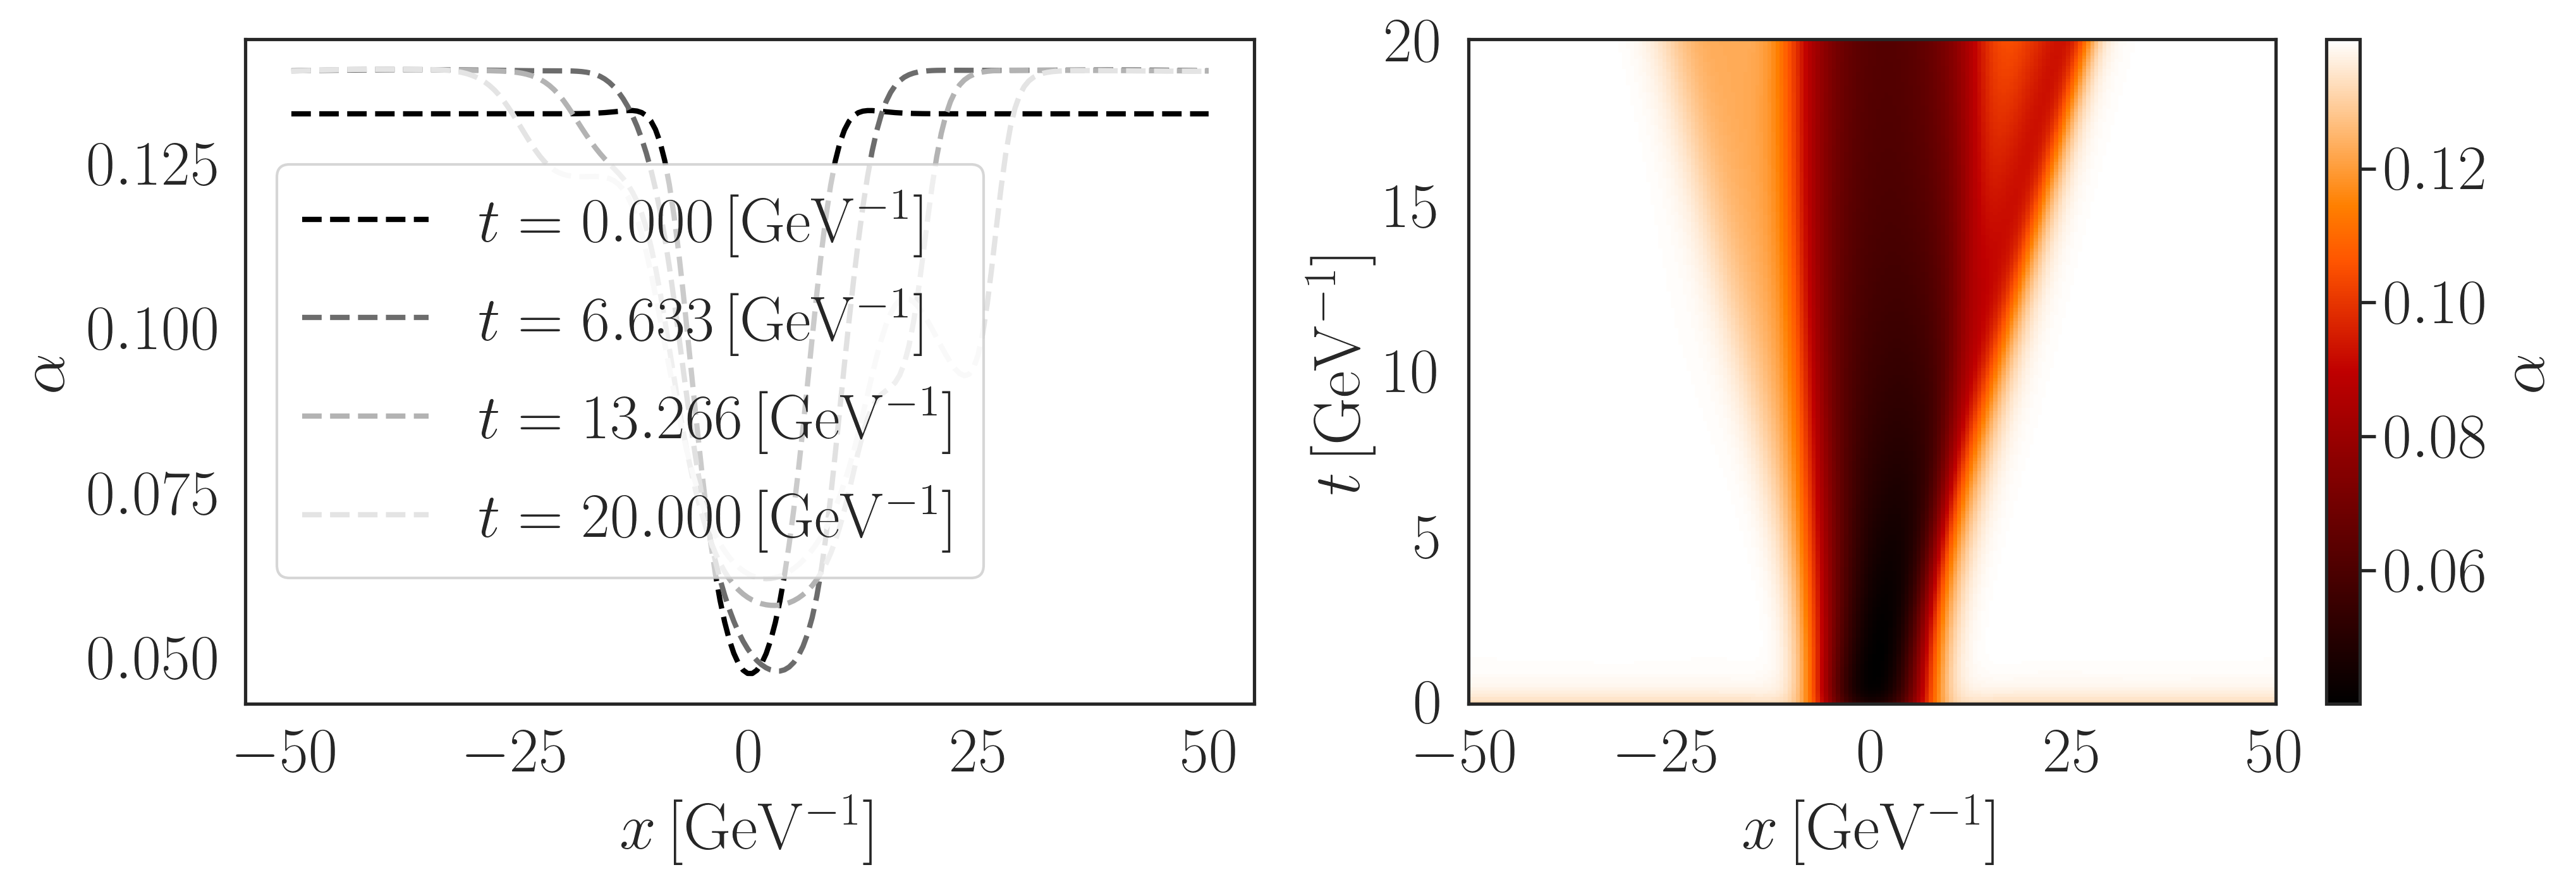

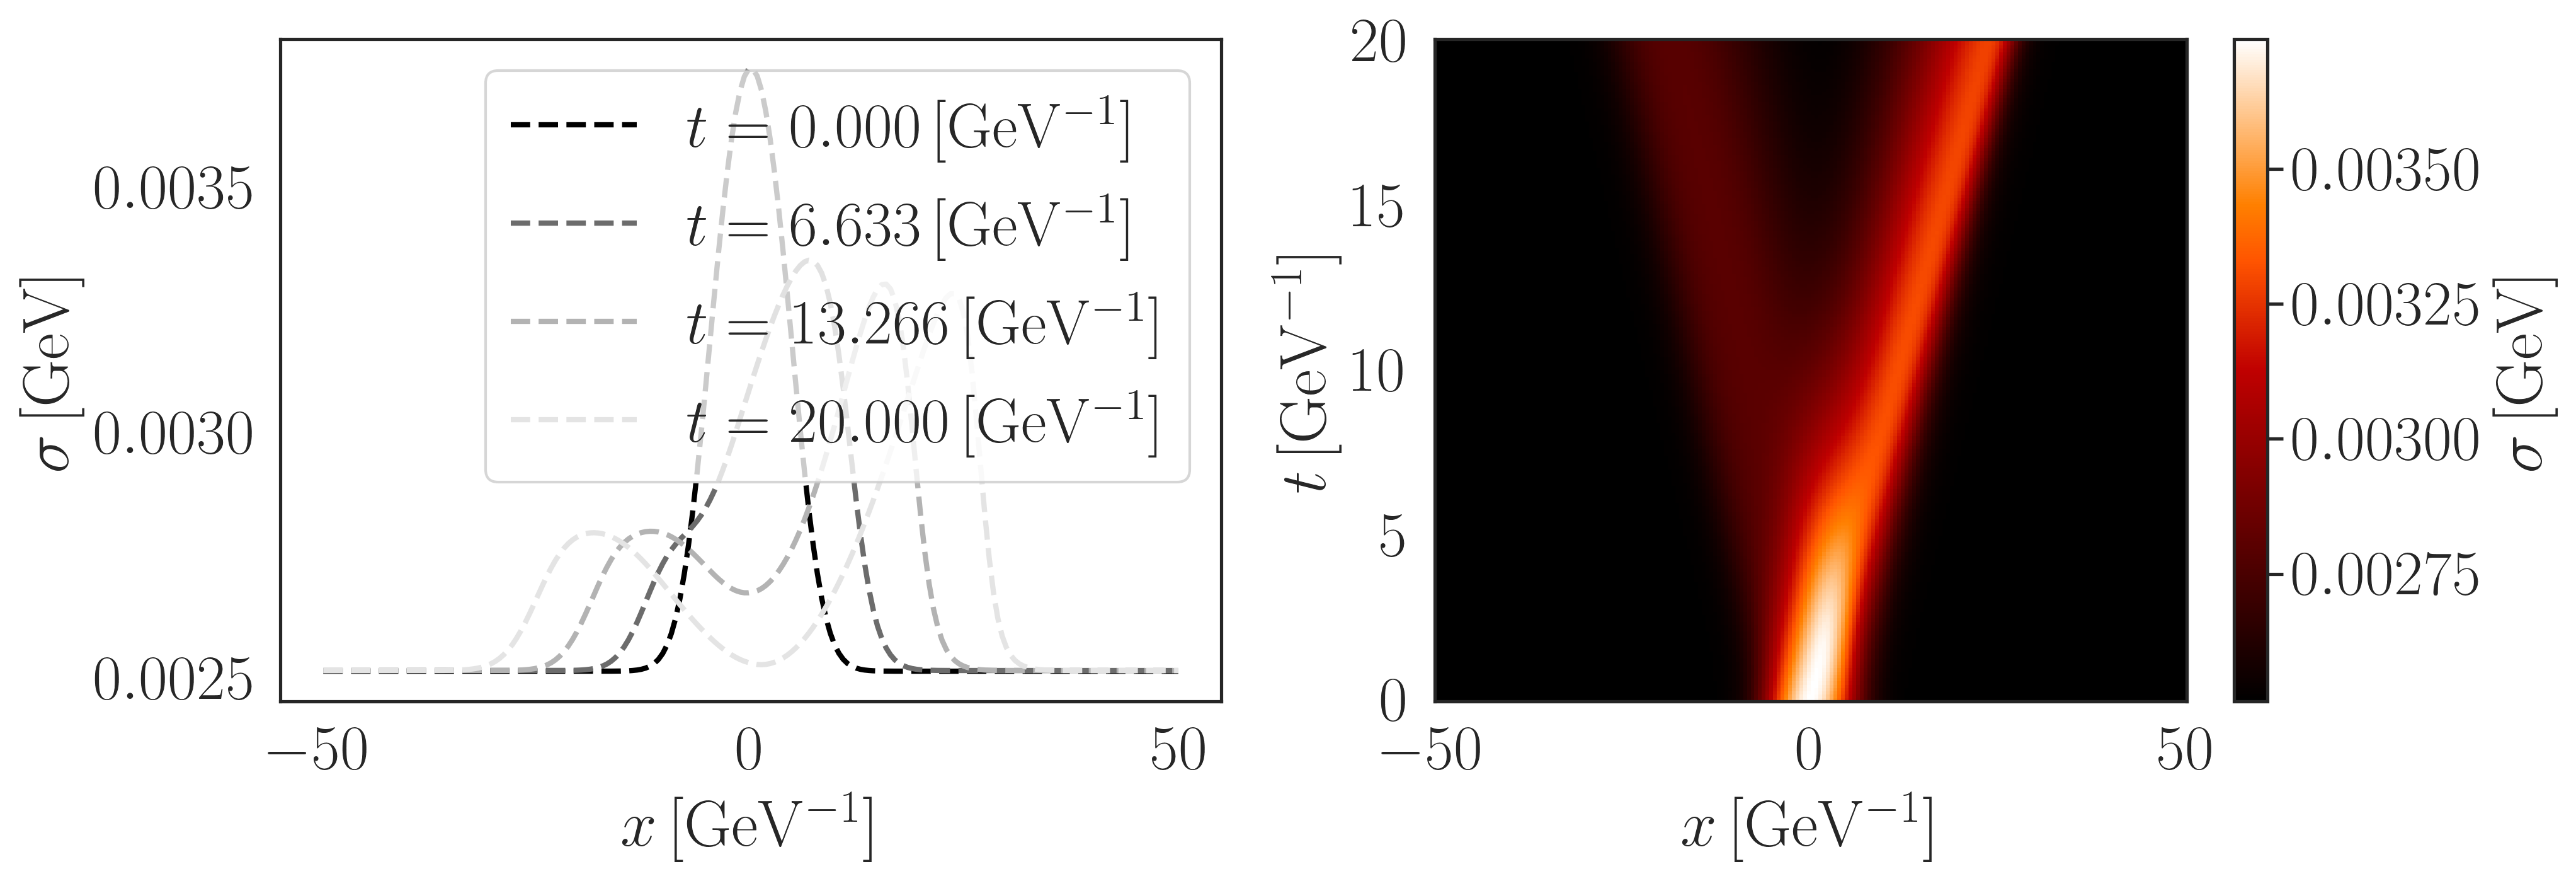

In [ ]:
from Plotting import *

plot_collocation_points(X_colloc, X_ic=None, X_bc_L=None, X_bc_R=None, L=L, t_end=t_end)

J0_ic_np    = J0_ic_t.detach().cpu().numpy()
alpha_ic_np = alpha_ic_t.detach().cpu().numpy()

x_edges_eval = np.linspace(-L, L, 200+1)
x_eval = 0.5 * (x_edges_eval[:-1] + x_edges_eval[1:])
t_eval = np.linspace(0, t_end, 200)

plot_results(
    model,
    t_eval=t_eval,
    x_eval=x_eval,
    alpha_ic=alpha_ic_t.detach().cpu().numpy(),
    J0_ic=J0_ic_t.detach().cpu().numpy()
)

with torch.enable_grad():
    plot_pde_residuals(model, t_eval, x_eval)

lbfgs_history = {"all_inner_per_epoch": [lbfgs_loss_history]}
plot_combined_loss_history(adam_loss_history, lbfgs_history)

In [ ]:
# Save all results

import os, time
from typing import Dict, Any

def _as_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

@torch.no_grad()
def _eval_on_grid(model, t_eval: np.ndarray, x_eval: np.ndarray, batch_size: int = 32768):
    was_training = model.training
    model.eval()

    t_eval = np.asarray(t_eval, dtype=np.float32).ravel()
    x_eval = np.asarray(x_eval, dtype=np.float32).ravel()
    Nt, Nx = len(t_eval), len(x_eval)

    TT, XX = np.meshgrid(t_eval, x_eval, indexing='ij')
    TX = np.stack([TT.reshape(-1), XX.reshape(-1)], axis=1)
    
    TX_t = torch.tensor(TX, dtype=DTYPE, device=device, requires_grad=True)
    r_list = []
    with torch.enable_grad():
        for i in range(0, TX_t.shape[0], batch_size):
            r = model.pde_residual(TX_t[i:i+batch_size])
            r_list.append(r)
        r_all = torch.cat(r_list, dim=0)
    r_grid = r_all.view(Nt, Nx, -1).detach().cpu().numpy()

    pred_grid = None
    pred_names = None
    J0_grid = np.array([], dtype=np.float32)
    n_grid  = np.array([], dtype=np.float32)

    with torch.no_grad():
        y_list = []
        for i in range(0, TX.shape[0], batch_size):
            y = model(torch.tensor(TX[i:i+batch_size], dtype=DTYPE, device=device))

            if isinstance(y, (list, tuple)):
                parts = []
                for yi in y:
                    yi = yi if yi.ndim == 2 else yi.view(yi.shape[0], -1)
                    parts.append(yi)
                y = torch.cat(parts, dim=1)
                pred_names = [f"out{i}" for i in range(y.shape[1])]
            elif isinstance(y, dict):
                keys = list(y.keys())
                parts = []
                for k in keys:
                    yi = y[k]
                    yi = yi if yi.ndim == 2 else yi.view(yi.shape[0], -1)
                    parts.append(yi)
                y = torch.cat(parts, dim=1)
                pred_names = keys
            else:
                if y.ndim == 1:
                    y = y.unsqueeze(1)
                elif y.ndim > 2:
                    y = y.view(y.shape[0], -1)
                if pred_names is None:
                    pred_names = [f"out{i}" for i in range(y.shape[1])]

            y_list.append(y.detach().cpu())

        if y_list:
            y_all = torch.cat(y_list, dim=0).numpy()
            pred_grid = y_all.reshape(Nt, Nx, -1)

            j0_idx = 0
            alpha_idx = 1
            J0_grid = pred_grid[:, :, j0_idx].astype(np.float32)

            t_flat = torch.tensor(TT.reshape(-1, 1), dtype=DTYPE, device=device)
            x_flat = torch.tensor(XX.reshape(-1, 1), dtype=DTYPE, device=device)
            alpha_flat = torch.tensor(pred_grid[:, :, alpha_idx].reshape(-1, 1), dtype=DTYPE, device=device)
            T_flat = T_func(t_flat, x_flat)
            n_flat = n_from_alpha_func(alpha_flat, T_flat)
            n_grid = n_flat.view(Nt, Nx).detach().cpu().numpy().astype(np.float32)

    # restore mode
    if was_training:
        model.train()

    return {
        "t_eval": t_eval,
        "x_eval": x_eval,
        "TX": TX.astype(np.float32),
        "r_pde_grid": r_grid,
        "pred_grid": pred_grid if pred_grid is not None else None,
        "pred_names": np.array(pred_names, dtype=object) if pred_names is not None else None,
        "J0_grid": J0_grid,
        "n_grid":  n_grid,
    }

def _compute_residual_fields(model, t_eval: np.ndarray, x_eval: np.ndarray):
    model.eval()

    p = next(model.parameters())
    dev, dty = p.device, p.dtype

    t_eval = np.asarray(t_eval, dtype=np.float64).ravel()
    x_eval = np.asarray(x_eval, dtype=np.float64).ravel()
    Nt, Nx = len(t_eval), len(x_eval)

    tt, xx = np.meshgrid(t_eval, x_eval, indexing='ij')
    tx = np.column_stack([tt.ravel(), xx.ravel()])
    tx_tensor = torch.tensor(tx, dtype=dty, device=dev, requires_grad=True)

    def grad(u):
        return torch.autograd.grad(
            u, tx_tensor, grad_outputs=torch.ones_like(u),
            create_graph=True, retain_graph=True
        )[0]

    with torch.set_grad_enabled(True):
        out   = model(tx_tensor)
        J0    = out[:, 0:1]
        alpha = out[:, 1:2]

        t = tx_tensor[:, 0:1]
        x = tx_tensor[:, 1:2]

        T     = T_func(t, x)
        v     = v_func(t, x)
        gamma = gamma_func(v)

        n     = n_from_alpha_func(alpha, T)
        sigma = sigma_func(alpha, T)
        lambd = lambd_func(sigma)

        a_g     = grad(alpha)
        alpha_t = a_g[:, 0:1]
        alpha_x = a_g[:, 1:2]
        N_x     = -alpha_x

        J0_t = grad(J0)[:, 0:1]

        N_0 = N_0_func(lambd, sigma, T, J0, n, N_x, v)
        Jx  = Jx_func(n, sigma, lambd, T, N_x, N_0, v)

        # R1
        Jx_x = grad(Jx)[:, 1:2]
        R1   = J0_t + Jx_x

        # R2
        R2   = alpha_t + N_0

        # R0
        helper   = alpha_t + v * alpha_x
        d_gn_dt  = grad(gamma * n)[:, 0:1]
        d_gnv_dx = grad(gamma * n * v)[:, 1:2]
        d_lt_dt  = grad((gamma**2) * lambd * T * helper)[:, 0:1]
        d_lx_dx  = grad((gamma**2) * v * lambd * T * helper)[:, 1:2]
        Wt       = -alpha_t + (gamma**2) * helper
        Wx       =  alpha_x + (gamma**2) * v * helper
        d_st_dt  = grad(sigma * T * Wt)[:, 0:1]
        d_sx_dx  = grad(sigma * T * Wx)[:, 1:2]
        R0 = d_gn_dt + d_gnv_dx + d_lt_dt + d_lx_dx - d_st_dt - d_sx_dx 

    def to_grid(Tv):
        return Tv.detach().cpu().numpy().reshape(Nt, Nx)

    return {
        "R1_grid": to_grid(R1),
        "R2_grid": to_grid(R2),
        "R0_grid": to_grid(R0),
    }

res_fields = _compute_residual_fields(model, t_eval=t_eval, x_eval=x_eval)
grid_dump = _eval_on_grid(model, t_eval=t_eval, x_eval=x_eval)
run_id = time.strftime("%Y%m%d-%H%M%S")
save_dir = os.path.abspath("./pinn_runs")
os.makedirs(save_dir, exist_ok=True)
dump_path = os.path.join(save_dir, f"PINN_run_dump_{run_id}.npz")

lbfgs_all_inner = np.array(lbfgs_history["all_inner_per_epoch"], dtype=object) if "all_inner_per_epoch" in lbfgs_history else np.array([], dtype=object)
lbfgs_inner_curve_np = np.asarray(lbfgs_loss_history, dtype=np.float64)

np.savez_compressed(
    dump_path,
    run_id=run_id, dtype=str(DTYPE), device_type=str(device.type),
    t_end=float(t_end), L=float(L),

    X_colloc=_as_numpy(X_colloc),
    X_bc_L=_as_numpy(X_bc_L) if 'X_bc_L' in globals() and X_bc_L is not None else np.array([]),
    X_bc_R=_as_numpy(X_bc_R) if 'X_bc_R' in globals() and X_bc_R is not None else np.array([]),
    x_ic=_as_numpy(x_ic), t_ic=_as_numpy(t_ic),
    alpha_ic=_as_numpy(alpha_ic_np), J0_ic=_as_numpy(J0_ic_np),

    t_eval=grid_dump["t_eval"], x_eval=grid_dump["x_eval"], TX=grid_dump["TX"],
    pred_grid=grid_dump["pred_grid"] if grid_dump["pred_grid"] is not None else np.array([]),
    pred_names=grid_dump["pred_names"] if grid_dump["pred_names"] is not None else np.array([], dtype=object),
    J0_grid=grid_dump["J0_grid"],
    n_grid=grid_dump["n_grid"],
    r_pde_grid=grid_dump["r_pde_grid"],

    R1_grid=res_fields["R1_grid"],
    R2_grid=res_fields["R2_grid"],
    R0_grid=res_fields["R0_grid"],

    adam_loss_history=np.asarray(adam_loss_history, dtype=np.float64),
    lbfgs_final_per_epoch=np.asarray(lbfgs_history.get("final_per_epoch", []), dtype=np.float64),
    lbfgs_best_inner_per_epoch=np.asarray(lbfgs_history.get("best_inner_per_epoch", []), dtype=np.float64),
    lbfgs_num_closure_calls=np.asarray(lbfgs_history.get("num_closure_calls", []), dtype=np.int32),
    lbfgs_all_inner_per_epoch=lbfgs_all_inner,

    lbfgs_inner_curve=lbfgs_inner_curve_np,
)
print(f"[save] Dumped replot data to: {dump_path}")
